In [86]:
import pandas as pd, numpy as np, networkx as nx

In [87]:
exr = pd.DataFrame({'PLN':[1.,4.34,3.93,0.061,0.055,0.2],
                    'EUR':[0.23,1.,0.9,0.014,0.013,0.047],
                    'USD':[0.25,1.11,1.,0.015,0.014,0.052],
                    'RUB':[16.43,71.4,64.52,1.,0.9,3.33],
                    'INR':[18.21,79.09,71.48,1.11,1.,3.69],
                    'MXN':[4.94,21.44,19.37,0.3,0.27,1.]},
                  index=['PLN','EUR','USD','RUB','INR','MXN'])
exr

,PLN,EUR,USD,RUB,INR,MXN
PLN,1.000,0.230,0.250,16.43,18.21,4.94
EUR,4.340,1.000,1.110,71.40,79.09,21.44
USD,3.930,0.900,1.000,64.52,71.48,19.37
RUB,0.061,0.014,0.015,1.00,1.11,0.30
INR,0.055,0.013,0.014,0.90,1.00,0.27
MXN,0.200,0.047,0.052,3.33,3.69,1.00


На единицу валюты из [index] можно купить R_ij единиц валюты из [columns]

In [88]:
weights = exr.apply(lambda x: -np.log(x))
weights

,PLN,EUR,USD,RUB,INR,MXN
PLN,-0.000000,1.469676,1.386294,-2.799109,-2.901971,-1.597365
EUR,-1.467874,-0.000000,-0.104360,-4.268298,-4.370586,-3.065258
USD,-1.368639,0.105361,-0.000000,-4.166975,-4.269418,-2.963725
RUB,2.796881,4.268698,4.199705,-0.000000,-0.104360,1.203973
INR,2.900422,4.342806,4.268698,0.105361,-0.000000,1.309333
MXN,1.609438,3.057608,2.956512,-1.202972,-1.305626,-0.000000


In [89]:
0.013*79.09

1.02817

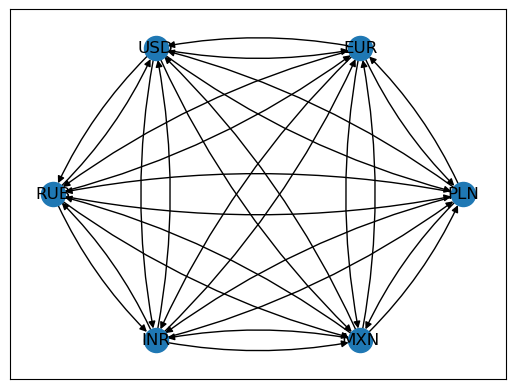

In [90]:
nodes = ['PLN','EUR','USD','RUB','INR','MXN']
edges = []
for i in weights.index:
    for j in weights.columns:
        if i != j:
        #if weights.loc[i,j] !=0:
            edges.append((i,j,weights.loc[i,j]))
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)
nx.draw_networkx(G, pos=nx.circular_layout(G),connectionstyle=f'arc3, rad = {0.1}', arrows=True)
labels = nx.get_edge_attributes(G,'weight')
#a=nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G), edge_labels=labels,font_size=8)

In [91]:
len(edges)

30

In [92]:
(weights+weights.T).apply(lambda x: x<0)

,PLN,EUR,USD,RUB,INR,MXN
PLN,False,False,False,True,True,False
EUR,False,False,False,False,True,True
USD,False,False,False,False,True,True
RUB,True,False,False,False,False,False
INR,True,True,True,False,False,False
MXN,False,True,True,False,False,False


In [93]:
#Отрицательные циклы из 2 вершин
n=len(nodes)
wt=(weights+weights.T).apply(lambda x: x<0)
for i in range(0,n):
    for j in range(i+1,n):
        if wt.iloc[i,j]:
            print ((exr.index[i], exr.columns[j],exr.index[i]), round((exr.iloc[i,j]*exr.iloc[j,i]-1)*100,4),'%')

('PLN', 'RUB', 'PLN') 0.223 %
('PLN', 'INR', 'PLN') 0.155 %
('EUR', 'INR', 'EUR') 2.817 %
('EUR', 'MXN', 'EUR') 0.768 %
('USD', 'INR', 'USD') 0.072 %
('USD', 'MXN', 'USD') 0.724 %


In [94]:
#Отрицательные треугольники
for i in range(0,n):
    for j in range(i+1,n):
        for k in range (i+1,n):
            if (k==j): continue
            if weights.iloc[i,j] + weights.iloc[j,k] + weights.iloc[k,i] <0:
                print(nodes[i], nodes[j], nodes[k], nodes[i], round((exr.iloc[i,j]*exr.iloc[j,k]*exr.iloc[k,i]-1)*100,4),'%')
        

PLN EUR USD PLN 0.3329 %
PLN EUR RUB PLN 0.1742 %
PLN EUR INR PLN 0.0489 %
PLN RUB INR PLN 0.3051 %
PLN INR EUR PLN 2.7408 %
PLN INR USD PLN 0.1914 %
PLN MXN EUR PLN 0.7661 %
PLN MXN USD PLN 0.9538 %
PLN MXN RUB PLN 0.3462 %
PLN MXN INR PLN 0.2573 %
EUR USD RUB EUR 0.2641 %
EUR USD INR EUR 3.1456 %
EUR USD MXN EUR 1.0533 %
EUR RUB INR EUR 3.0302 %
EUR RUB MXN EUR 0.674 %
EUR INR MXN EUR 0.3652 %
EUR MXN USD EUR 0.3392 %
EUR MXN INR EUR 2.8477 %
USD RUB INR USD 0.2641 %
USD RUB MXN USD 0.6512 %
USD INR MXN USD 0.3579 %
USD MXN INR USD 0.0654 %


In [95]:
def dists(u):
    inf=1e6
    n=len(nodes)
    #u='PLN'
    A0=np.zeros((n,n))
    A0.fill(inf)
    #A0[0,0] = 0.
    A=pd.DataFrame(A0, index=nodes)
    P=A.copy()
    A.loc[u,0]=0
    for i in range(1,n):
        for j in edges:
            if A.loc[j[1],i] > A.loc[j[0],i-1] + j[2]:
                A.loc[j[1],i] = A.loc[j[0],i-1] + j[2]
                P.loc[j[1],i] = j[0]
    return (A,P)

In [96]:
A,P = dists('PLN')

 A[i,j] содержит длину кратчайшего пути из s в i, содержащего j рёбер

In [97]:
A

,0,1,2,3,4,5
PLN,0.0,999998.532126,-0.002228,-0.027039,-0.032164,-0.054820
EUR,1000000.0,1.469676,1.440835,1.439337,1.413055,1.409863
USD,1000000.0,1.386294,1.359146,1.336475,1.332088,1.308694
RUB,1000000.0,-2.799109,-2.800338,-2.827463,-2.830500,-2.855243
INR,1000000.0,-2.901971,-2.903469,-2.929751,-2.932943,-2.957532
MXN,1000000.0,-1.597365,-1.595582,-1.624423,-1.627250,-1.652204


 P [i,j] содержит предыдущую вершину до i в одном из кратчайших путей

In [98]:
P

,0,1,2,3,4,5
PLN,1000000.0,EUR,RUB,EUR,USD,EUR
EUR,1000000.0,PLN,INR,INR,INR,INR
USD,1000000.0,PLN,MXN,EUR,MXN,EUR
RUB,1000000.0,PLN,MXN,EUR,USD,EUR
INR,1000000.0,PLN,RUB,EUR,USD,EUR
MXN,1000000.0,PLN,EUR,EUR,USD,EUR


dist1 делает на 1 цикл больше. В датафрейме А в строке u будут минимальные пути циклов длиной (номер столбца).

In [99]:
def dists1(u):
    inf=1e6
    n=len(nodes)
    #u='PLN'
    A0=np.zeros((n,n+1))
    A0.fill(inf)
    #A0[0,0] = 0.
    A=pd.DataFrame(A0, index=nodes)
    P=A.copy()
    A.loc[u,0]=0
    for i in range(1,n+1):
        for j in edges:
            if A.loc[j[1],i] > A.loc[j[0],i-1] + j[2]:
                A.loc[j[1],i] = A.loc[j[0],i-1] + j[2]
                P.loc[j[1],i] = j[0]
    return (A,P)

In [100]:
A1,P1 = dists1('PLN')

In [101]:
A1

,0,1,2,3,4,5,6
PLN,0.0,999998.532126,-0.002228,-0.027039,-0.032164,-0.054820,-0.059945
EUR,1000000.0,1.469676,1.440835,1.439337,1.413055,1.409863,1.385274
USD,1000000.0,1.386294,1.359146,1.336475,1.332088,1.308694,1.304308
RUB,1000000.0,-2.799109,-2.800338,-2.827463,-2.830500,-2.855243,-2.858435
INR,1000000.0,-2.901971,-2.903469,-2.929751,-2.932943,-2.957532,-2.960723
MXN,1000000.0,-1.597365,-1.595582,-1.624423,-1.627250,-1.652204,-1.655395


In [102]:
P1

,0,1,2,3,4,5,6
PLN,1000000.0,EUR,RUB,EUR,USD,EUR,USD
EUR,1000000.0,PLN,INR,INR,INR,INR,INR
USD,1000000.0,PLN,MXN,EUR,MXN,EUR,MXN
RUB,1000000.0,PLN,MXN,EUR,USD,EUR,EUR
INR,1000000.0,PLN,RUB,EUR,USD,EUR,EUR
MXN,1000000.0,PLN,EUR,EUR,USD,EUR,EUR


sh_u_n по матрицам А и Р, посчитанных для вершины u, восстанавливает кратчайший цикл длины n, не содержащий внутренних циклов. Если кратчайший цикл содержит внутренние циклы, возвращает 1000000 (=inf).

In [103]:
def sh_u_n(u,n,A,P):
    sh=[]*n
    u1=u
    sh.append(u)
    for i in range (n,1,-1):
        un= P.loc[u1,i]
        if sh.count(un)>0: return ([],1000000) # минимальный цикл этого размера содержит внутренние циклы
        sh.append(un)
        u1=un
    sh.append(u)
    arb=round((np.exp(-A.loc[u,n]) - 1)*100, 4) # арбитраж по циклу в %%
    return sh[::-1], arb
    

In [104]:
sh_u_n('PLN',2,A1,P1)

(['PLN', 'RUB', 'PLN'], 0.223)

Все кратчайшие циклы, содеержащие u

In [105]:
def pr_cycles(u,A,P):
    n=len(A.index)
    for i in range(n,1,-1):
        sh,arb = sh_u_n(u,i,A,P)
        if arb<1000000:
            print(sh,arb,'%')
    return

In [106]:
pr_cycles('PLN',A1,P1)

['PLN', 'INR', 'EUR', 'USD', 'PLN'] 3.2687 %
['PLN', 'INR', 'EUR', 'PLN'] 2.7408 %
['PLN', 'RUB', 'PLN'] 0.223 %


Все кратчайшие циклы без внутренних

In [107]:
for u in nodes:
    A2,P2 = dists1(u)
    pr_cycles(u,A2,P2)

['PLN', 'INR', 'EUR', 'USD', 'PLN'] 3.2687 %
['PLN', 'INR', 'EUR', 'PLN'] 2.7408 %
['PLN', 'RUB', 'PLN'] 0.223 %
['EUR', 'USD', 'INR', 'EUR'] 3.1456 %
['EUR', 'INR', 'EUR'] 2.817 %
['USD', 'INR', 'EUR', 'MXN', 'USD'] 3.5991 %
['USD', 'INR', 'EUR', 'USD'] 3.1456 %
['USD', 'MXN', 'USD'] 0.724 %
['RUB', 'INR', 'EUR', 'USD', 'RUB'] 3.3436 %
['RUB', 'INR', 'EUR', 'RUB'] 3.0302 %
['RUB', 'PLN', 'RUB'] 0.223 %
['INR', 'EUR', 'USD', 'INR'] 3.1456 %
['INR', 'EUR', 'INR'] 2.817 %
['MXN', 'INR', 'EUR', 'MXN'] 2.8477 %
['MXN', 'EUR', 'MXN'] 0.768 %
